In [ ]:
from random import shuffle
import glob
import tensorflow as tf
import cv2
import sys
import numpy as np
shuffle_data = False  # shuffle the addresses before saving

img_list=a.image_list
label_list=a.label_list

def load_image(addr):
    # read an image and resize to (224, 224)
    # cv2 load images as BGR, convert it to RGB
    img = cv2.imread(addr)
    img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_CUBIC)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)
    return img

def _int64_feature(value):
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _bytes_feature(value):
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

train_filename = 'train.tfrecords'  # address to save the TFRecords file
# open the TFRecords file
writer = tf.python_io.TFRecordWriter(train_filename)

for i in range(len(img_list)):
    # print how many images are saved every 1000 images
    if not i % 1000:
        print('Train data: {}/{}'.format(i, len(img_list)))
        sys.stdout.flush()
    # Load the image
    img = load_image(img_list[i])
    label = load_image(label_list[i])
    
    # Create a feature
    feature = {'train/label': _bytes_feature(tf.compat.as_bytes(label.tostring())),
               'train/image': _bytes_feature(tf.compat.as_bytes(img.tostring()))}
    b=tf.train.Features(feature=feature)
    # Create an example protocol buffer
    example = tf.train.Example(features=b)
    
    # Serialize to string and write on the file
    writer.write(example.SerializeToString())
    
writer.close()
sys.stdout.flush()    

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
data_path = 'train.tfrecords'  # address to save the hdf5 file
with tf.Session() as sess:
    feature = {'train/image': tf.FixedLenFeature([], tf.string),
               'train/label': tf.FixedLenFeature([], tf.string)}
    # Create a list of filenames and pass it to a queue
    filename_queue = tf.train.string_input_producer([data_path], num_epochs=2)
    # Define a reader and read the next record
    reader = tf.TFRecordReader()
    _, serialized_example = reader.read(filename_queue)
    # Decode the record read by the reader
    features = tf.parse_single_example(serialized_example, features=feature)
    # Convert the image data from string back to the numbers
    image = tf.decode_raw(features['train/image'], tf.float32)
    label = tf.decode_raw(features['train/label'], tf.float32)
    
    # Cast label data into int32
    #label = tf.cast(features['train/label'], tf.int32)
    # Reshape image data into the original shape
    image = tf.reshape(image, [224, 224, 3])
    label = tf.reshape(label, [224, 224, 3])
    # Any preprocessing here ...
    
    # Creates batches by randomly shuffling tensors
    images, labels = tf.train.batch([image, label], batch_size=5, capacity=30, num_threads=1)
        # Initialize all global and local variables
    
    init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
    sess.run(init_op)
    # Create a coordinator and run all QueueRunner objects
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    i=0
    try:
        while not coord.should_stop():
            i=i+1
            if not i % 1:
                print('Train data: {}'.format(i))
                print(labels.shape)
                sys.stdout.flush()
            img1, lbl1 = sess.run([images, labels])
            if i==294:
                aaaa=img1
            
    except tf.errors.OutOfRangeError:
        print('Done training, epoch reached')
        #img1, lbl1 = sess.run([images, labels])
        
        #img = img1.astype(np.uint8)
        #lbl = lbl1.astype(np.uint8)
        
        #for j in range(10):
        #    plt.subplot(2, 5, j+1)
        #    #plt.imshow(img[j, ...])
            
        #    plt.imshow(lbl[j, ...])
        ##plt.show()
        #for j in range(10):
        #    plt.subplot(2, 5, j+1)
        #    plt.imshow(img[j, ...])
        #plt.show()
    # Stop the threads
    coord.request_stop()
    
    # Wait for threads to stop
    coord.join(threads)
    sess.close()

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
data_path = 'train.tfrecords'  # address to save the hdf5 file
sess=tf.Session()
feature = {'train/image': tf.FixedLenFeature([], tf.string),
           'train/label': tf.FixedLenFeature([], tf.string)}
# Create a list of filenames and pass it to a queue
filename_queue = tf.train.string_input_producer([data_path], num_epochs=1)
# Define a reader and read the next record
reader = tf.TFRecordReader()
_, serialized_example = reader.read(filename_queue)
# Decode the record read by the reader
features = tf.parse_single_example(serialized_example, features=feature)
# Convert the image data from string back to the numbers
image = tf.decode_raw(features['train/image'], tf.float32)
label = tf.decode_raw(features['train/label'], tf.float32)

# Cast label data into int32
#label = tf.cast(features['train/label'], tf.int32)
# Reshape image data into the original shape
image = tf.reshape(image, [224, 224, 3])
label = tf.reshape(label, [224, 224, 3])
# Any preprocessing here ...

# Creates batches by randomly shuffling tensors
images, labels = tf.train.shuffle_batch([image, label], batch_size=10, capacity=30, num_threads=1, min_after_dequeue=10)
    # Initialize all global and local variables

init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
sess.run(init_op)
# Create a coordinator and run all QueueRunner objects
coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(coord=coord)
for batch_index in range(1):
    img1, lbl1 = sess.run([images, labels])

    img = img1.astype(np.uint8)
    lbl = lbl1.astype(np.uint8)

    for j in range(10):
        plt.subplot(2, 5, j+1)
        #plt.imshow(img[j, ...])

        plt.imshow(lbl[j, ...])
    plt.show()
    for j in range(10):
        plt.subplot(2, 5, j+1)
        plt.imshow(img[j, ...])
    plt.show()
# Stop the threads
coord.request_stop()

# Wait for threads to stop
coord.join(threads)
sess.close()

In [1]:
from random import shuffle
import glob
import tensorflow as tf
import cv2
import sys
import numpy as np

#image read
from PIL import Image # image class read
import skimage.io as io # image rgb read

#data_list read

def _int64_feature(value):
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _bytes_feature(value):
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


def read_labeled_image_list(data_dir, data_list):
    """Reads txt file containing paths to images and ground truth masks.

    Args:
      data_dir: path to the directory with images and masks.
      data_list: path to the file with lines of the form '/path/to/image /path/to/mask'.

    Returns:
      Two lists with all file names for images and masks, respectively.
    """
    f = open(data_list, 'r')
    images = []
    masks = []
    for line in f:
        try:
            image = mask = line.strip("\n")
        except ValueError: # Adhoc for test.
            image = mask = line.strip("\n")
        images.append(data_dir + '/JPEGImages/'+image+'.jpg')
        masks.append(data_dir + '/SegmentationClass/'+mask+'.png')
    return images, masks

def write_images_from_disk_tfrecord(img_list, label_list,tfrecords_filename): # optional pre-processing arguments
    """Read one image and its corresponding mask with optional pre-processing.

    Args:

    Returns:
      Two tensors: the decoded image and its mask.
    """
    writer = tf.python_io.TFRecordWriter(tfrecords_filename)

    # Let's collect the real images to later on compare
    # to the reconstructed ones
    original_images = []
    filename_pairs=zip(img_list,label_list)
    i=0
    for img_path, annotation_path in filename_pairs:
        i=i+1
        if not i % 100:
            print('Train data: {}/{}'.format(i, len(img_list)))
            sys.stdout.flush()

        img = np.array(Image.open(img_path))
        annotation = np.array(Image.open(annotation_path))

        # The reason to store image sizes was demonstrated
        # in the previous example -- we have to know sizes
        # of images to later read raw serialized string,
        # convert to 1d array and convert to respective
        # shape that image used to have.
        height = img.shape[0]
        width = img.shape[1]

        # Put in the original images into array
        # Just for future check for correctness
        #original_images.append((img, annotation))

        img_raw = img.tostring()
        annotation_raw = annotation.tostring()

        example = tf.train.Example(features=tf.train.Features(feature={
            'height': _int64_feature(height),
            'width': _int64_feature(width),
            'image_raw': _bytes_feature(img_raw),
            'mask_raw': _bytes_feature(annotation_raw)}))
        writer.write(example.SerializeToString())
    writer.close()

class ImageReader(object):
    '''Generic ImageReader which reads images and corresponding segmentation
       masks from the disk, and enqueues them into a TensorFlow queue.
    '''

    def __init__(self, data_dir, data_list,tfrecords_filename,input_size):#, input_size, random_scale, random_mirror, img_mean, coord):
        '''Initialise an ImageReader.
        
        Args:
          train_data_dir: ////////////////////path to the directory with images and masks.
          label_data_dir: ////////////////////path to the file with lines of the form '/path/to/image /path/to/mask'.
          input_size: a tuple with (height, width) values, to which all the images will be resized.
          random_scale: whether to randomly scale the images prior to random crop.
          random_mirror: whether to randomly mirror the images prior to random crop.
          ignore_label: index of label to ignore during the training.
          img_mean: vector of mean colour values.
          coord: TensorFlow queue coordinator.
        '''
        self.data_dir = data_dir
        self.data_list = data_list
        self.input_size = input_size
        self.tfrecords_filename = tfrecords_filename

        self.image_list, self.label_list = read_labeled_image_list(self.data_dir, self.data_list)               
        write_images_from_disk_tfrecord(self.image_list, self.label_list,self.tfrecords_filename) 
        

    
    def read_and_decode(self,tfrecords_filename,epochs,batch_size):
        filename_queue = tf.train.string_input_producer([tfrecords_filename], num_epochs=epochs)

        IMAGE_HEIGHT, IMAGE_WIDTH = self.input_size    
        reader = tf.TFRecordReader()
        _, serialized_example = reader.read(filename_queue)

        features = tf.parse_single_example(
          serialized_example,
          # Defaults are not specified since both keys are required.
          features={
            'height': tf.FixedLenFeature([], tf.int64),
            'width': tf.FixedLenFeature([], tf.int64),
            'image_raw': tf.FixedLenFeature([], tf.string),
            'mask_raw': tf.FixedLenFeature([], tf.string)
            })

        # Convert from a scalar string tensor (whose single string has
        # length mnist.IMAGE_PIXELS) to a uint8 tensor with shape
        # [mnist.IMAGE_PIXELS].
        
        image = tf.decode_raw(features['image_raw'], tf.uint8)
        annotation = tf.decode_raw(features['mask_raw'], tf.uint8)

        height = tf.cast(features['height'], tf.int32)
        width = tf.cast(features['width'], tf.int32)

        image_shape = tf.stack([height, width, 3])
        annotation_shape = tf.stack([height, width, 1])

        image = tf.reshape(image, image_shape)
        annotation = tf.reshape(annotation, annotation_shape)

        image_size_const = tf.constant((IMAGE_HEIGHT, IMAGE_WIDTH, 3), dtype=tf.int32)
        annotation_size_const = tf.constant((IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype=tf.int32)

        # Random transformations can be put here: right before you crop images
        # to predefined size. To get more information look at the stackoverflow
        # question linked above.

        resized_image = tf.image.resize_image_with_crop_or_pad(image=image,
                                               target_height=IMAGE_HEIGHT,
                                               target_width=IMAGE_WIDTH)

        resized_annotation = tf.image.resize_image_with_crop_or_pad(image=annotation,
                                               target_height=IMAGE_HEIGHT,
                                               target_width=IMAGE_WIDTH)


        images, annotations = tf.train.shuffle_batch( [resized_image, resized_annotation],
                                                     batch_size=batch_size,
                                                     capacity=30,
                                                     num_threads=2,
                                                     min_after_dequeue=10)

        return images, annotations



In [2]:
DATA_DIRECTORY = '/media/jeongjaepark/PERL/NeuralNetworkDataset/PascalVOCC/VOC2012/train/VOCdevkit/VOC2012'
DATA_LIST_PATH = '/media/jeongjaepark/PERL/NeuralNetworkDataset/PascalVOCC/VOC2012/train/VOCdevkit/VOC2012/ImageSets/Segmentation/train.txt'

tfrecords_filename = 'pascal_voc_segmentation.tfrecords'
input_size=(332,332)
train_data=ImageReader(DATA_DIRECTORY,DATA_LIST_PATH,tfrecords_filename,input_size)

Train data: 100/1464
Train data: 200/1464
Train data: 300/1464
Train data: 400/1464
Train data: 500/1464
Train data: 600/1464
Train data: 700/1464
Train data: 800/1464
Train data: 900/1464
Train data: 1000/1464
Train data: 1100/1464
Train data: 1200/1464
Train data: 1300/1464
Train data: 1400/1464


In [4]:
image,annotation=train_data.read_and_decode(tfrecords_filename,2,5)
init_op = tf.group(tf.global_variables_initializer(),tf.local_variables_initializer())
with tf.Session()  as sess:
    sess.run(init_op)
    
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    # Let's read off 3 batches just for example

    i=0
    try:
        while not coord.should_stop():
            i=i+1
            if not i % 100:
                print('Train data: {}'.format(i))
                sys.stdout.flush()
            img, anno = sess.run([image, annotation])
            
    except tf.errors.OutOfRangeError:
        print('Done training, epoch reached')
    
    #img1, anno1 = sess.run([image, annotation])
    coord.request_stop()
    # Wait for threads to stop
    coord.join(threads)
    sess.close()

Train data: 100
Train data: 200
Train data: 300
Train data: 400
Train data: 500
Done training, epoch reached


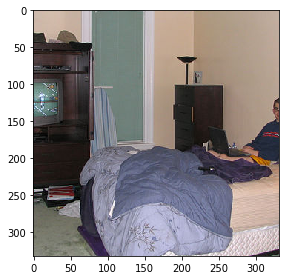

In [5]:
io.imshow(img[0, :, :, :])
io.show()

In [ ]:
%matplotlib inline

# Important: We are using PIL to read .png files later.
# This was done on purpose to read indexed png files
# in a special way -- only indexes and not map the indexes
# to actual rgb values. This is specific to PASCAL VOC
# dataset data. If you don't want thit type of behaviour
# consider using skimage.io.imread()

from PIL import Image
import numpy as np
import skimage.io as io
import tensorflow as tf


def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

tfrecords_filename = 'pascal_voc_segmentation.tfrecords'

writer = tf.python_io.TFRecordWriter(tfrecords_filename)

# Let's collect the real images to later on compare
# to the reconstructed ones
original_images = []
filename_pairs=zip(img_list,label_list)
i=0
for img_path, annotation_path in filename_pairs:
    i=i+1
    if not i % 100:
        print('Train data: {}/{}'.format(i, len(img_list)))
        sys.stdout.flush()
    
    img = np.array(Image.open(img_path))
    annotation = np.array(Image.open(annotation_path))
    
    # The reason to store image sizes was demonstrated
    # in the previous example -- we have to know sizes
    # of images to later read raw serialized string,
    # convert to 1d array and convert to respective
    # shape that image used to have.
    height = img.shape[0]
    width = img.shape[1]
    
    # Put in the original images into array
    # Just for future check for correctness
    #original_images.append((img, annotation))
    
    img_raw = img.tostring()
    annotation_raw = annotation.tostring()
    
    example = tf.train.Example(features=tf.train.Features(feature={
        'height': _int64_feature(height),
        'width': _int64_feature(width),
        'image_raw': _bytes_feature(img_raw),
        'mask_raw': _bytes_feature(annotation_raw)}))
    
    writer.write(example.SerializeToString())

writer.close()

In [ ]:

reconstructed_images = []

record_iterator = tf.python_io.tf_record_iterator(path=tfrecords_filename)
for string_record in record_iterator:
    example = tf.train.Example()
    example.ParseFromString(string_record)
    
    height = int(example.features.feature['height']
                                 .int64_list
                                 .value[0])
    
    width = int(example.features.feature['width']
                                .int64_list
                                .value[0])
    
    img_string = (example.features.feature['image_raw']
                                  .bytes_list
                                  .value[0])
    
    annotation_string = (example.features.feature['mask_raw']
                                .bytes_list
                                .value[0])
    
    img_1d = np.fromstring(img_string, dtype=np.uint8)
    reconstructed_img = img_1d.reshape((height, width, -1))
    
    annotation_1d = np.fromstring(annotation_string, dtype=np.uint8)
    # Annotations don't have depth (3rd dimension)
    reconstructed_annotation = annotation_1d.reshape((height, width))
    
    reconstructed_images.append((reconstructed_img, reconstructed_annotation))

In [ ]:
%matplotlib inline

import tensorflow as tf
import skimage.io as io

IMAGE_HEIGHT = 384
IMAGE_WIDTH = 384

tfrecords_filename = 'pascal_voc_segmentation.tfrecords'

def read_and_decode(filename_queue):
    
    reader = tf.TFRecordReader()

    _, serialized_example = reader.read(filename_queue)

    features = tf.parse_single_example(
      serialized_example,
      # Defaults are not specified since both keys are required.
      features={
        'height': tf.FixedLenFeature([], tf.int64),
        'width': tf.FixedLenFeature([], tf.int64),
        'image_raw': tf.FixedLenFeature([], tf.string),
        'mask_raw': tf.FixedLenFeature([], tf.string)
        })

    # Convert from a scalar string tensor (whose single string has
    # length mnist.IMAGE_PIXELS) to a uint8 tensor with shape
    # [mnist.IMAGE_PIXELS].
    image = tf.decode_raw(features['image_raw'], tf.uint8)
    annotation = tf.decode_raw(features['mask_raw'], tf.uint8)
    
    height = tf.cast(features['height'], tf.int32)
    width = tf.cast(features['width'], tf.int32)
    
    image_shape = tf.stack([height, width, 3])
    annotation_shape = tf.stack([height, width, 1])
    
    image = tf.reshape(image, image_shape)
    annotation = tf.reshape(annotation, annotation_shape)
    
    image_size_const = tf.constant((IMAGE_HEIGHT, IMAGE_WIDTH, 3), dtype=tf.int32)
    annotation_size_const = tf.constant((IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype=tf.int32)
    
    # Random transformations can be put here: right before you crop images
    # to predefined size. To get more information look at the stackoverflow
    # question linked above.
    
    resized_image = tf.image.resize_image_with_crop_or_pad(image=image,
                                           target_height=IMAGE_HEIGHT,
                                           target_width=IMAGE_WIDTH)
    
    resized_annotation = tf.image.resize_image_with_crop_or_pad(image=annotation,
                                           target_height=IMAGE_HEIGHT,
                                           target_width=IMAGE_WIDTH)
    
    
    images, annotations = tf.train.shuffle_batch( [resized_image, resized_annotation],
                                                 batch_size=2,
                                                 capacity=30,
                                                 num_threads=2,
                                                 min_after_dequeue=10)
    
    return images, annotations

In [ ]:
filename_queue = tf.train.string_input_producer(
    [tfrecords_filename], num_epochs=10)

# Even when reading in multiple threads, share the filename
# queue.
image, annotation = read_and_decode(filename_queue)

# The op for initializing the variables.
init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())

with tf.Session()  as sess:
    
    sess.run(init_op)
    
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    
    # Let's read off 3 batches just for example
    for i in range(3):
    
        img, anno = sess.run([image, annotation])
        print(img[0, :, :, :].shape)
        
        print('current batch')
        
        # We selected the batch size of two
        # So we should get two image pairs in each batch
        # Let's make sure it is random

        io.imshow(img[0, :, :, :])
        io.show()

        io.imshow(anno[0, :, :, 0])
        io.show()
        
        io.imshow(img[1, :, :, :])
        io.show()

        io.imshow(anno[1, :, :, 0])
        io.show()
        
    
    coord.request_stop()
    coord.join(threads)



In [4]:
import numpy as np

In [13]:
a.shape

(1000, 1000, 1)

In [17]:
for i in a[][][:]:
    print(i)
    print('데헷')

SyntaxError: invalid syntax (<ipython-input-17-35b75711f00c>, line 1)

In [28]:
a

array([[[1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.]]])

In [27]:
import numpy as np

In [28]:
a=np.ones((1000,1000,1))
(h,w,_)=a.shape
background_labels=[1,2,3,4]
k=0
for i in range(h):
    for j in range(w):
        k=k+1
        a[i][j][0]=k

In [38]:
for i in range(h):
    for j in range(w):
        for lbl in background_labels:
            if a[i][j][0]==lbl:
                b=0
                break
            b=1
        a[i][j][0]=b
       

In [54]:
import numpy as np
background_labels=[1,2,3,4]
def compare(pix,background_lbls):
    if pix in background_lbls: b=0
    else: b=1
    return b
vfunc=np.vectorize(compare,excluded=['background_labels'])
vfunc(pix=a,background_lbls=background_labels)

In [71]:
vfunc=np.vectorize(compare,excluded=['background_labels'])
vfunc(pix=a,background_lbls=background_labels)

TypeError: argument of type 'numpy.int64' is not iterable

In [63]:
def myfunc(a, b):
#"Return a-b if a>b, otherwise return a+b"
    if a > b:
        return a - b
    else:
        return a + b

In [70]:
Vfunc=np.vectorize(myfunc)
Vfunc([1,2,3,4],[1])

array([2, 1, 2, 3])

In [73]:
def mypolyval(p,x):
    _p=list(p)
    res=_p.pop(0)
    while _p:
        res=res*x+_p.pop(0)
    return res
vpolyval=np.vectorize(mypolyval,excluded=['p'])
vpolyval(p=[1,2,3],x=[0,1])

array([3, 6])

In [34]:
a=[11,2,3,1,321,312]

In [38]:
type(a.

list

In [80]:
c=[1,2,3]
_c=list(c)
x=0
res=_c.pop(0)
while _c:
    res=res*x+_c.pop(0)
res

3

In [120]:
class label_processing():
    def __init__(self,pix,backbr_labels):
        self.backgr_labels=backbr_labels
        self.pix=pix
    
    def compare_label(self):
        def compare(pix):
            if pix in self.backgr_labels: tmp=0
            else: tmp=1
            return tmp
        vfunc=np.vectorize(compare)
        
        return vfunc(self.pix)

In [121]:
c=label_processing(a,background_labels)

In [122]:
c.compare_label()

TypeError: compare() missing 1 required positional argument: 'background_lbls'

In [113]:
a

array([[[1.],
        [1.],
        [1.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       ...,

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]]])